In [58]:
import glob
import random
import numpy as np
import pandas as pd

### Load data

In [50]:
all_data = pd.read_pickle('mommy_thresholds3.pkl')
print(all_data.columns)
print(len(all_data.participant.unique()))

all_audiogram_data = pd.read_pickle('all_audiograms50_3AFCsampling_outliers_N28_longFormat.pkl')
print(all_audiogram_data.columns)

# all_audiogram_3AFC = pd.read_pickle('3AFC_df_4rev.pkl')

Index(['participant', 'paradigm', 'pred', 'time', 'frequency', 'prob_sum',
       'nHeard', 'nTrials', 'difference', 'tested_freqs', 'tested_levels',
       'tested_probas', 'API_p', 'thresholds', 'thresholds_Cluster',
       'threshold_distance', 'threshold_distance_Cluster',
       'threshold_distance_Continuous', 'thresholds_Continuous', 'tone_number',
       'yi', 'partial_deltaP', 'probability_grid', 'gmsi_score',
       'diff_with_none', 'outlier', 'mommy_probability_grid',
       'mommy_audiogram', 'mommy_threshold', 'mommy_threshold_distance'],
      dtype='object')
28
Index(['participant', 'paradigm', 'pred', 'time', 'frequency', 'frequencies',
       'thresholds', 'mean_threshold'],
      dtype='object')


## Choose a participant

In [104]:
participant = 'erfnpg'
while participant == 'erfnpg':
    participant = random.choice(all_data.participant.unique())
# participant = 'cwzopc', 'nunamh'
print(participant)

data = all_data[all_data['participant'] == participant]
audiogram_data = all_audiogram_data[all_audiogram_data['participant'] == participant]
path_3AFC = f"/Users/nadou/Documents/Documents - Nadège’s MacBook Air/GitHub/predictive-audiograms/RAW_DATA/{participant}/3AFC/"
trials_3AFC = pd.read_pickle(glob.glob(f"{path_3AFC}*.pkl")[0])
trials_3AFC = trials_3AFC.rename(columns={'Frequency': 'tested_freqs', 'Level': 'tested_levels'})
trials_3AFC.insert(len(trials_3AFC.columns), 'tone_number', np.linspace(1, len(trials_3AFC), len(trials_3AFC), dtype=int))
# audiogram_3AFC = all_audiograms_3AFC[all_audiograms_3AFC['participant'] == participant]

print(len(data))

nfsmrp
654


## 3-AFC data

In [105]:
# Filter by paradigm
data_3AFC = data[data.paradigm == '3AFC']
data_3AFC = pd.merge(data_3AFC, trials_3AFC, on=['tested_freqs', 'tested_levels', 'tone_number'])
audiogram_3AFC = audiogram_data[audiogram_data.paradigm == '3-AFC']

# Randomly select a tested frequency
# chosen_freq = np.random.choice(data_3AFC.tested_freqs.unique())
chosen_freq = 1000.0
print("Chosen frequency:", chosen_freq)

# Select rows with the chosen frequency
data_3AFC = data_3AFC[data_3AFC.tested_freqs == chosen_freq]

reversal_levels = []
reversal_indices = []
for reversal, direction in data_3AFC[data_3AFC.tested_freqs == chosen_freq].groupby(['Reversals']):
    reversal_levels.append(direction.tested_levels.iloc[-1])
    reversal_indices.append(direction.tone_number.iloc[-1])
print(f"{participant} N REVERSALS: {len(reversal_levels)}")
print(reversal_levels)
reversal_levels = reversal_levels[:6]
reversal_indices = reversal_indices[:6]
print(reversal_levels, reversal_indices)

# Estimate the threshold at this frequency as the average of the last 4 reversal levels
threshold = np.round(np.nanmean(reversal_levels[-4:]), 1)
reversal_levels = reversal_levels[-4:]
reversal_indices = reversal_indices[-4:]
print(reversal_levels, reversal_indices)

# Get the threshold for that frequency
# threshold = audiogram_3AFC[audiogram_3AFC.Frequency == chosen_freq].Level

print("3-AFC threshold:", threshold, "dB HL")

Chosen frequency: 1000.0
nfsmrp N REVERSALS: 7
[0.0, 5.0, -5.0, 5.0, 0.0, 5.0, 0.0]
[0.0, 5.0, -5.0, 5.0, 0.0, 5.0] [5, 7, 8, 15, 16, 19]
[-5.0, 5.0, 0.0, 5.0] [8, 15, 16, 19]
3-AFC threshold: 1.2 dB HL


/var/folders/n2/6h405_jj4gx_hk24mxws_nfr0000gn/T/ipykernel_55724/4182740534.py:52: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,10000])


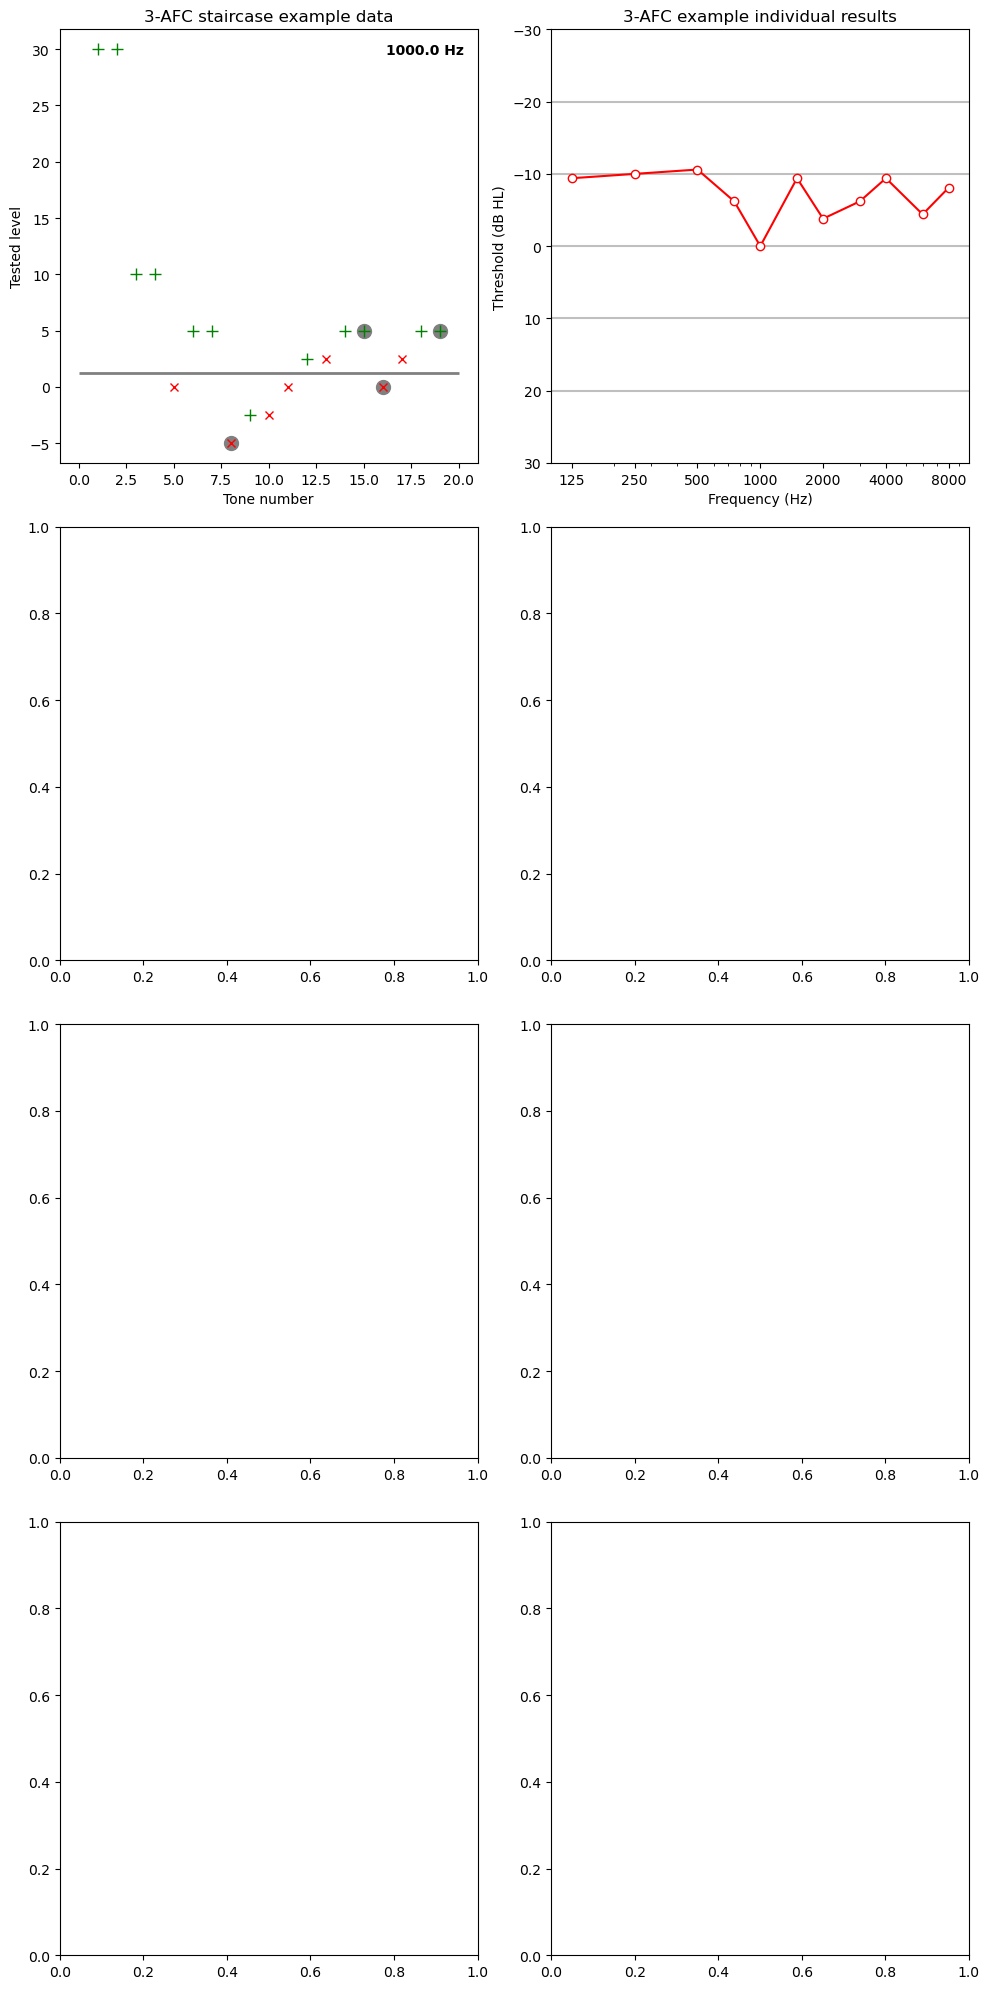

In [106]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=[10, 20])

#FIRST PLOT
plt.sca(axes[0, 0])

# Find the index of the first tone
# min_idx = data_3AFC.tone_number.min()

# Plot a horizontal line for the corresponding threshold
plt.hlines(y=threshold,
          xmin=0, xmax=data_3AFC.tone_number.max(),
          colors='grey', lw=2)

# Show the reversals used for threshold computation
plt.scatter(reversal_indices, reversal_levels, marker='o', s=100, c='grey')

# Loop over the rows in the DataFrame
for index, row in data_3AFC.iterrows():
    if index == len(data_3AFC) - 1:
        continue
    # Check the value of 'yi'
    if row['yi'] == 1:  # Plot a green checkmark
        plt.plot(row['tone_number'], row['tested_levels'], 'g+', markersize=8)
    else:  # Plot a red cross
        plt.plot(row['tone_number'], row['tested_levels'], 'rx', markersize=6)

# Add text in the top-right corner with the selected frequency
plt.annotate(f'{chosen_freq} Hz', xy=(1, 1), xytext=(-10, -10),
            xycoords='axes fraction', textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            fontweight='bold')

# Add labels to the axes
plt.xlabel('Tone number')
plt.ylabel('Tested level')
plt.title('3-AFC staircase example data')


# SECOND PLOT
plt.sca(axes[0, 1])

plt.hlines([-20, -10, 0, 10, 20], 0, 12000, colors='grey', alpha=0.5)
plt.plot(audiogram_3AFC.sort_values('frequencies').frequencies, audiogram_3AFC.sort_values('frequencies').thresholds, label=participant, color='red')
plt.scatter(audiogram_3AFC.frequencies, audiogram_3AFC.thresholds, label=None, edgecolors='red', facecolors="white", zorder=3)
plt.xscale('log')
# plt.legend()
plt.ylim([30, -30])
plt.xticks([125, 250, 500, 1000, 2000, 4000, 8000], [125, 250, 500, 1000, 2000, 4000, 8000])
plt.xlim([0,10000])
plt.ylabel("Threshold (dB HL)")
plt.xlabel('Frequency (Hz)')
plt.title('3-AFC example individual results')
plt.tight_layout()

# Show the plot
plt.show()